In [1]:
library(Seurat)

seurat = readRDS('initialSeurat.RDS')

Warning message:
"package 'Seurat' was built under R version 4.1.3"
Attaching SeuratObject

Attaching sp



In [2]:
seurat = UpdateSeuratObject(seurat)

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version



In [3]:
hashing_meta = readRDS('cellhashing/hashed_seurat_meta.RDS')
seurat$hash = hashing_meta[colnames(seurat), 'hash']
table(seurat$hash)


 Doublet     HTO1     HTO2     HTO3     HTO4     HTO5 Negative 
    3468    10067     7927     7132     4555     3699     3890 

In [4]:
seurat = subset(seurat, cells = colnames(seurat)[!seurat$hash %in% c('Negative', 'Doublet') & !is.na(seurat$hash)])

In [5]:
seurat

An object of class Seurat 
17220 features across 33380 samples within 1 assay 
Active assay: RNA (17220 features, 410 variable features)
 2 dimensional reductions calculated: pca, umap

In [6]:
seurat$letter = substring(seurat$orig, 1, 1)
ifnb.list <- SplitObject(seurat, split.by = "letter")

# normalize and identify variable features for each dataset independently
ifnb.list <- lapply(X = ifnb.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = ifnb.list)

In [7]:
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, anchor.features = features)
immune.combined <- IntegrateData(anchorset = immune.anchors, features.to.integrate = rownames(GetAssayData(seurat)))
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)


Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15791 anchors

Filtering anchors

	Retained 4363 anchors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [8]:
DefaultAssay(immune.combined) = 'integrated'
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindClusters(immune.combined, resolution = 0.4)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
10:35:01 UMAP embedding parameters a = 0.9922 b = 1.112

10:35:01 Read 33380 rows and found 30 numeric columns

10:35:02 Using Annoy for neighbor search, n_neighbors = 30

10:35:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:35:12 Writing NN index file to temp file C:\Users\dmorgan\AppData\Local\Temp\2\RtmpA3hlPo\file13c0164a216d

10:35:12 Searching Annoy index using 1 thread, search_k = 3000

10:35:29 Annoy recall = 100%

10:35:29 Commencing smooth kNN distance calibration using 1

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 33380
Number of edges: 1099826

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8925
Number of communities: 12
Elapsed time: 11 seconds


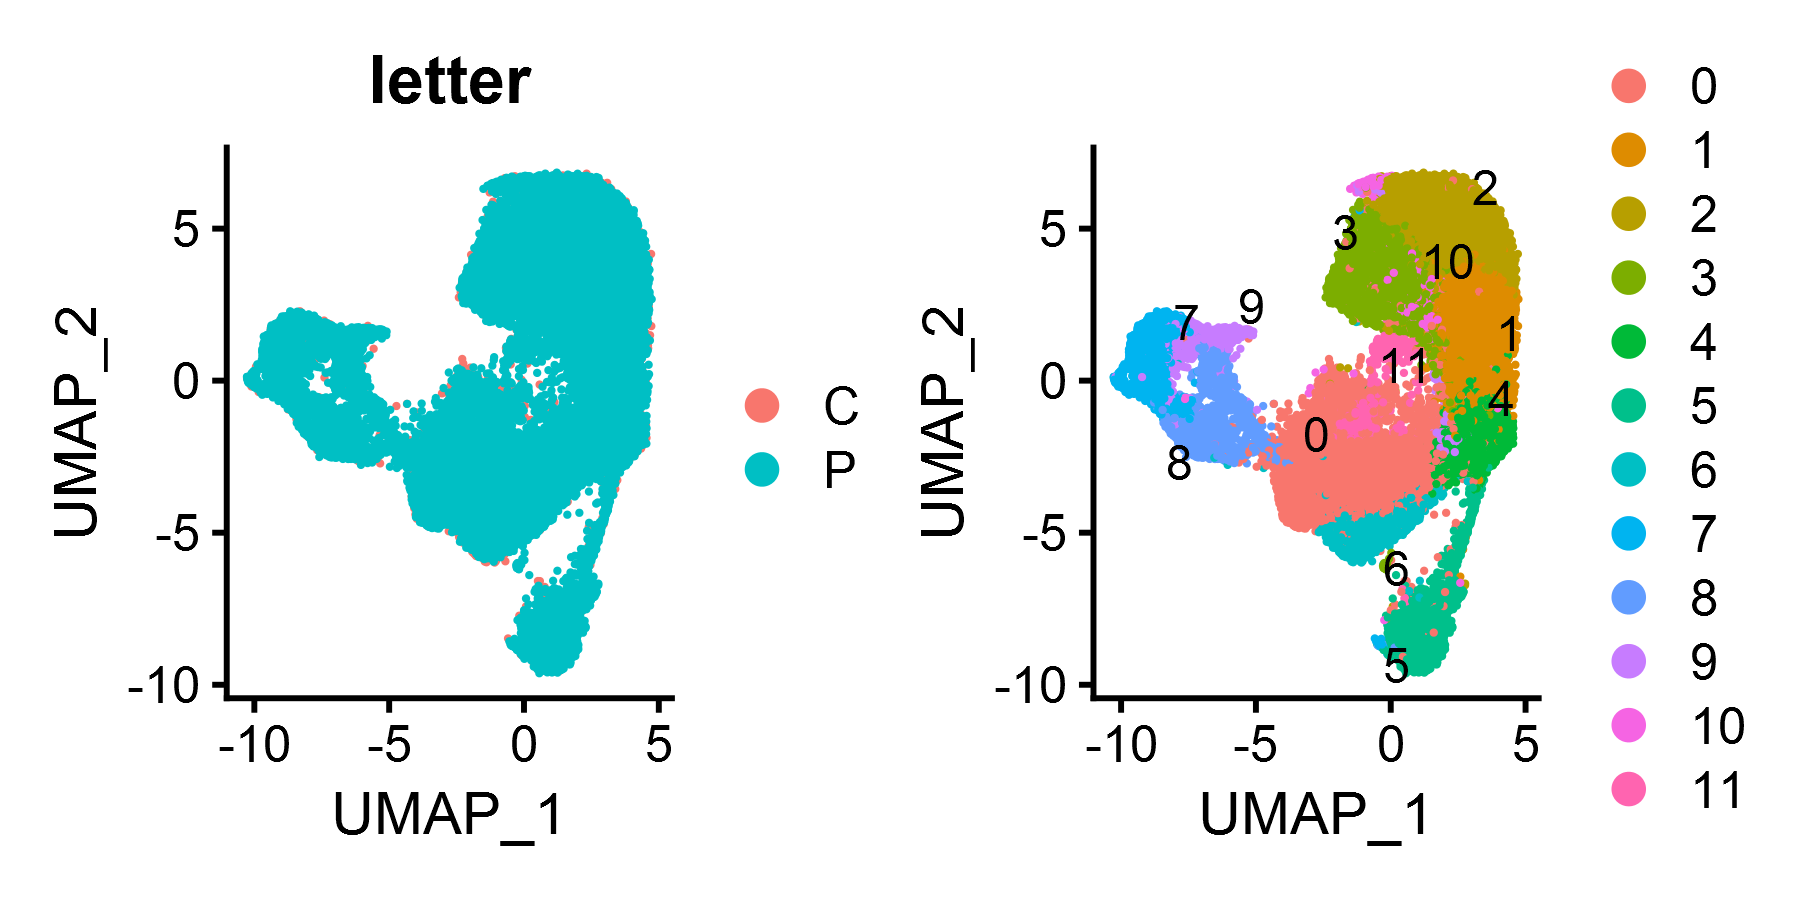

In [9]:
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 3)
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = "letter")
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

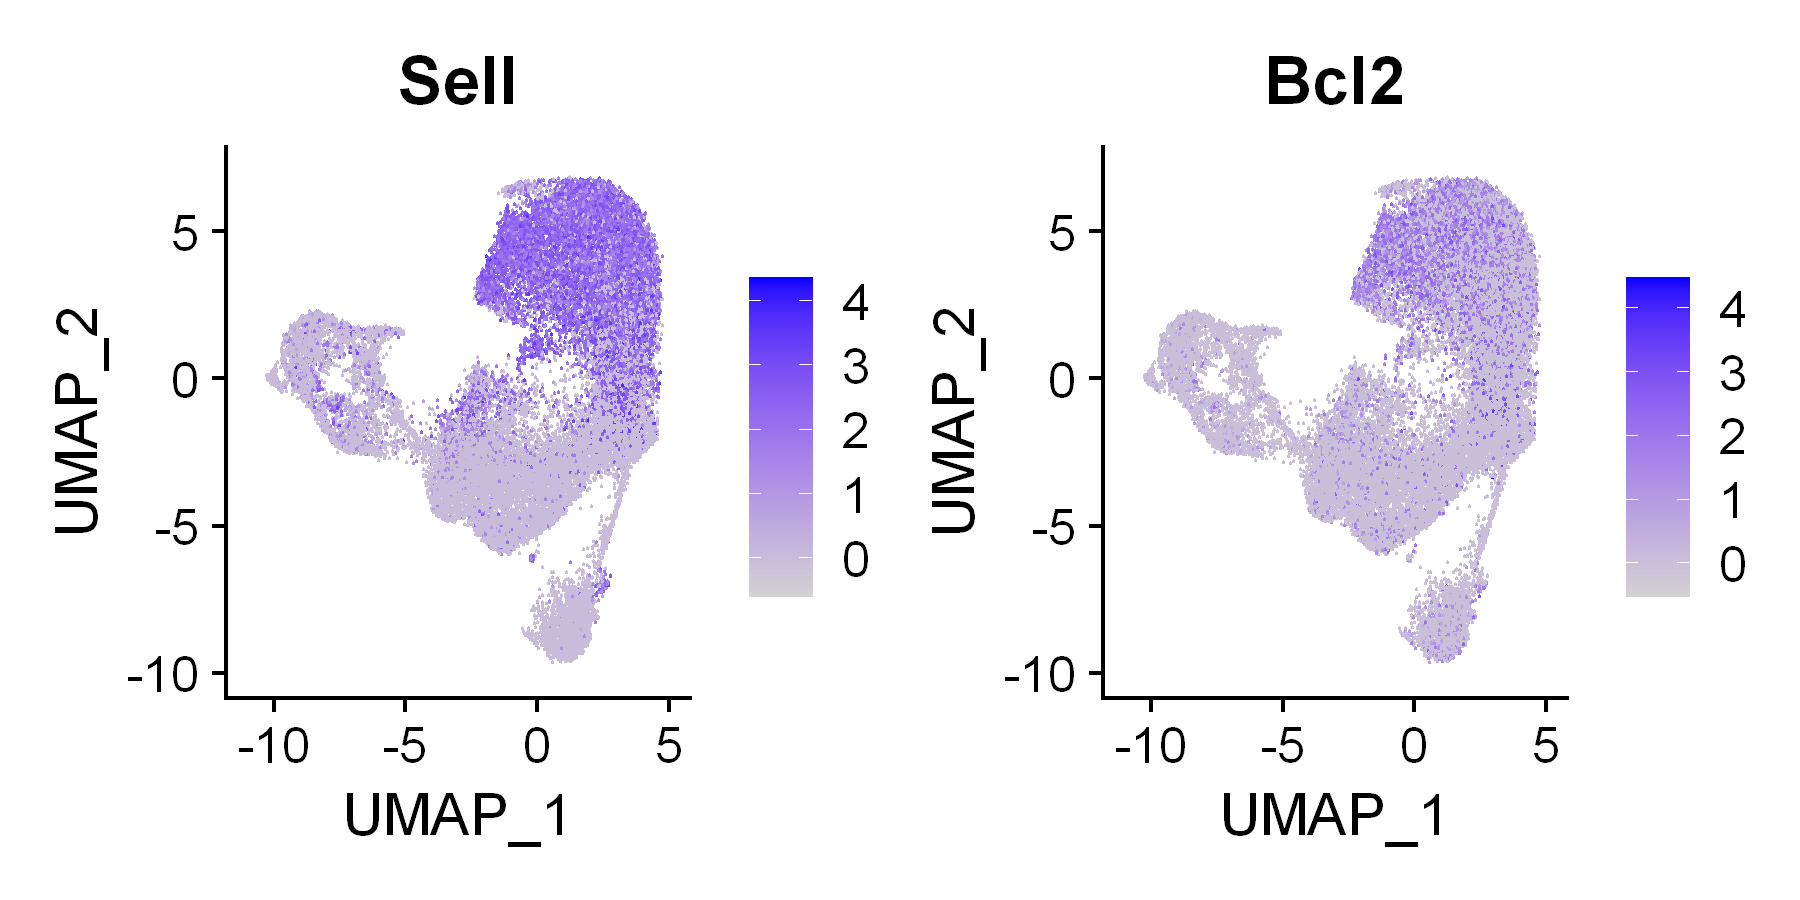

In [56]:
FeaturePlot(immune.combined, c('Sell', 'Bcl2'))

In [10]:
saveRDS(immune.combined, 'pre_naive_out.RDS')

In [64]:
seurat = subset(immune.combined, cells = colnames(immune.combined)[!Idents(immune.combined) %in% c(1,2,3)])

In [66]:
seurat

An object of class Seurat 
34440 features across 19037 samples within 2 assays 
Active assay: RNA (17220 features, 0 variable features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [67]:
library(Seurat)
library(stringr)

s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat = CellCycleScoring(seurat, s.features = str_to_title(s.genes), g2m.features = str_to_title(g2m.genes), set.ident = TRUE)

mito.genes = rownames(seurat)[grep(x = rownames(seurat), pattern = '^mt')]
DefaultAssay(seurat) = 'RNA'
seurat$percent.mito = colSums(seurat@assays$RNA@counts[mito.genes,]) /colSums(seurat@assays$RNA@counts )
summary(seurat$percent.mito)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05209 0.06937 0.08206 0.09113 0.94879 

Regressing out nFeature_RNA, percent.mito, S.Score, G2M.Score

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 10 features requested have zero variance (running reduction without them): Aldh1l2, Tbx19, Gm15270, Gm24145, Pygo1, Tdo2, Styxl1, Abcc2, P2rx5, Prss55"
PC_ 1 
Positive:  Tnfaip3, Rgs16, Vps37b, Pdcd1, Ctla4, Fosl2, Nr4a3, Icos, Crem, Sik1 
	   Nr4a2, Dusp5, Bhlhe40, Litaf, Dgat1, Pde4d, Ifngr1, Nr4a1, Tnfrsf1b, Tgif1 
	   Sh2d2a, Odc1, Dusp4, Skil, Neurl3, P2ry10, Mxd1, Tnfrsf9, Bcl2l11, Zc3h12a 
Negative:  Rasgrp2, Sell, Flna, Pycard, Dapl1, Ighg1, Id3, Gzma, Emp3, S1pr5 
	   Cdc25b, E2f2, Cd48, Gzmm, Fcgrt, Atic, Fam101b, Dnah8, Cd22, Il7r 
	   Racgap1, Itgb1, Sepp1, Myb, Tnfsf8, Ass1, Rxra, Cxcr5, Gm14446, Ifi27l2a 
PC_ 2 
Positive:  Lgals1, Ahnak, S100a10, Actb, S100a4, Vim, Lgals3, Anxa6, Crip1, Flna 
	   Tmsb4x, S100a6, Ccr2, Ccl5, Coro1a, Gzma, Calm1, Ppp1ca, Cd48, Gzmb 
	   Pycard, Cf

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18651
Number of edges: 721891

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8918
Number of communities: 10
Elapsed time: 7 seconds


2 singletons identified. 8 final clusters.

20:10:24 UMAP embedding parameters a = 0.9922 b = 1.112

20:10:24 Read 18651 rows and found 50 numeric columns

20:10:24 Using Annoy for neighbor search, n_neighbors = 30

20:10:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:10:31 Writing NN index file to temp file C:\Users\dmorgan\AppData\Local\Temp\1\Rtmp8AekIW\fileaa8360f11d

20:10:31 Searching Annoy index using 1 thread, search_k = 3000

20:10:39 Annoy recall = 100%

20:10:40 Commencing smooth kNN distance calibration using 1 thread

20:10:43 Initializing from normalized Laplacian + noise

20:10:44 Commencing optimization for 200 epochs, with 873980 positive edges

20:11:21 Optimization finished



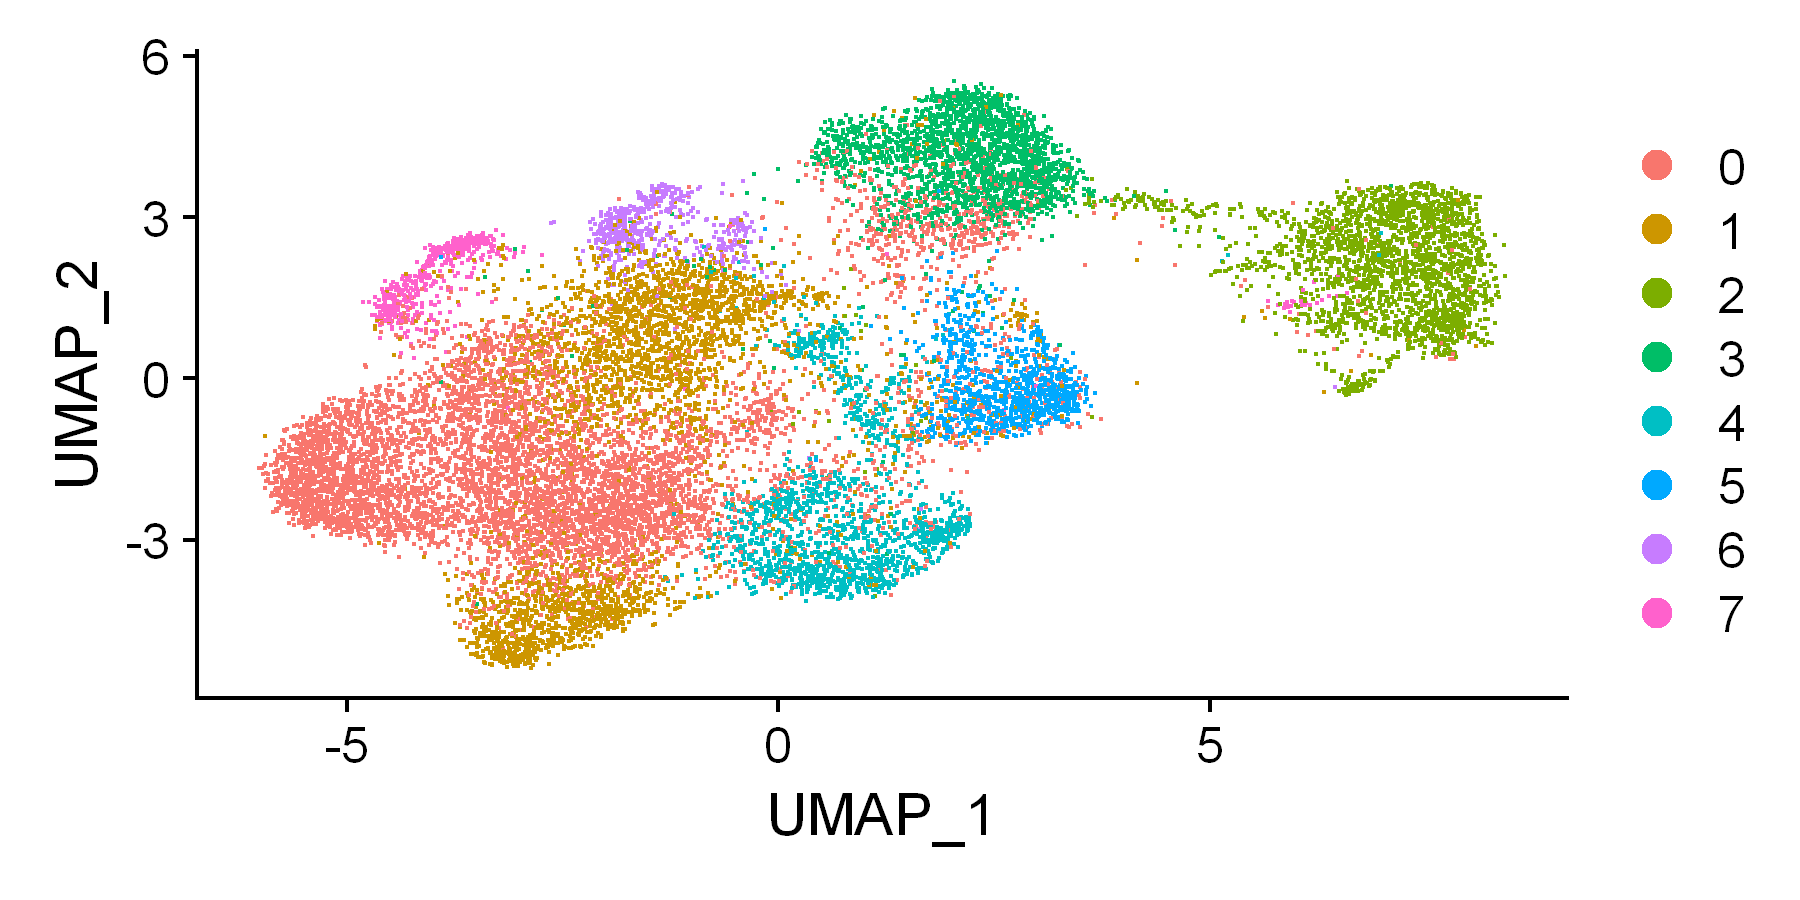

In [68]:
DefaultAssay(seurat) = 'integrated'
seurat = subset(seurat, cells = colnames(seurat)[seurat$percent.mito < .25])
seurat = ScaleData(seurat, vars.to.regress = c('nFeature_RNA', 'percent.mito', 'S.Score','G2M.Score'), features = VariableFeatures(seurat))
seurat = RunPCA(seurat, features = VariableFeatures(seurat), npcs = 100)
seurat = FindNeighbors(seurat, dims = 1:50)
seurat = FindClusters(seurat, resolution = .3)
seurat = RunUMAP(seurat, dims = 1:50)

DimPlot(seurat)

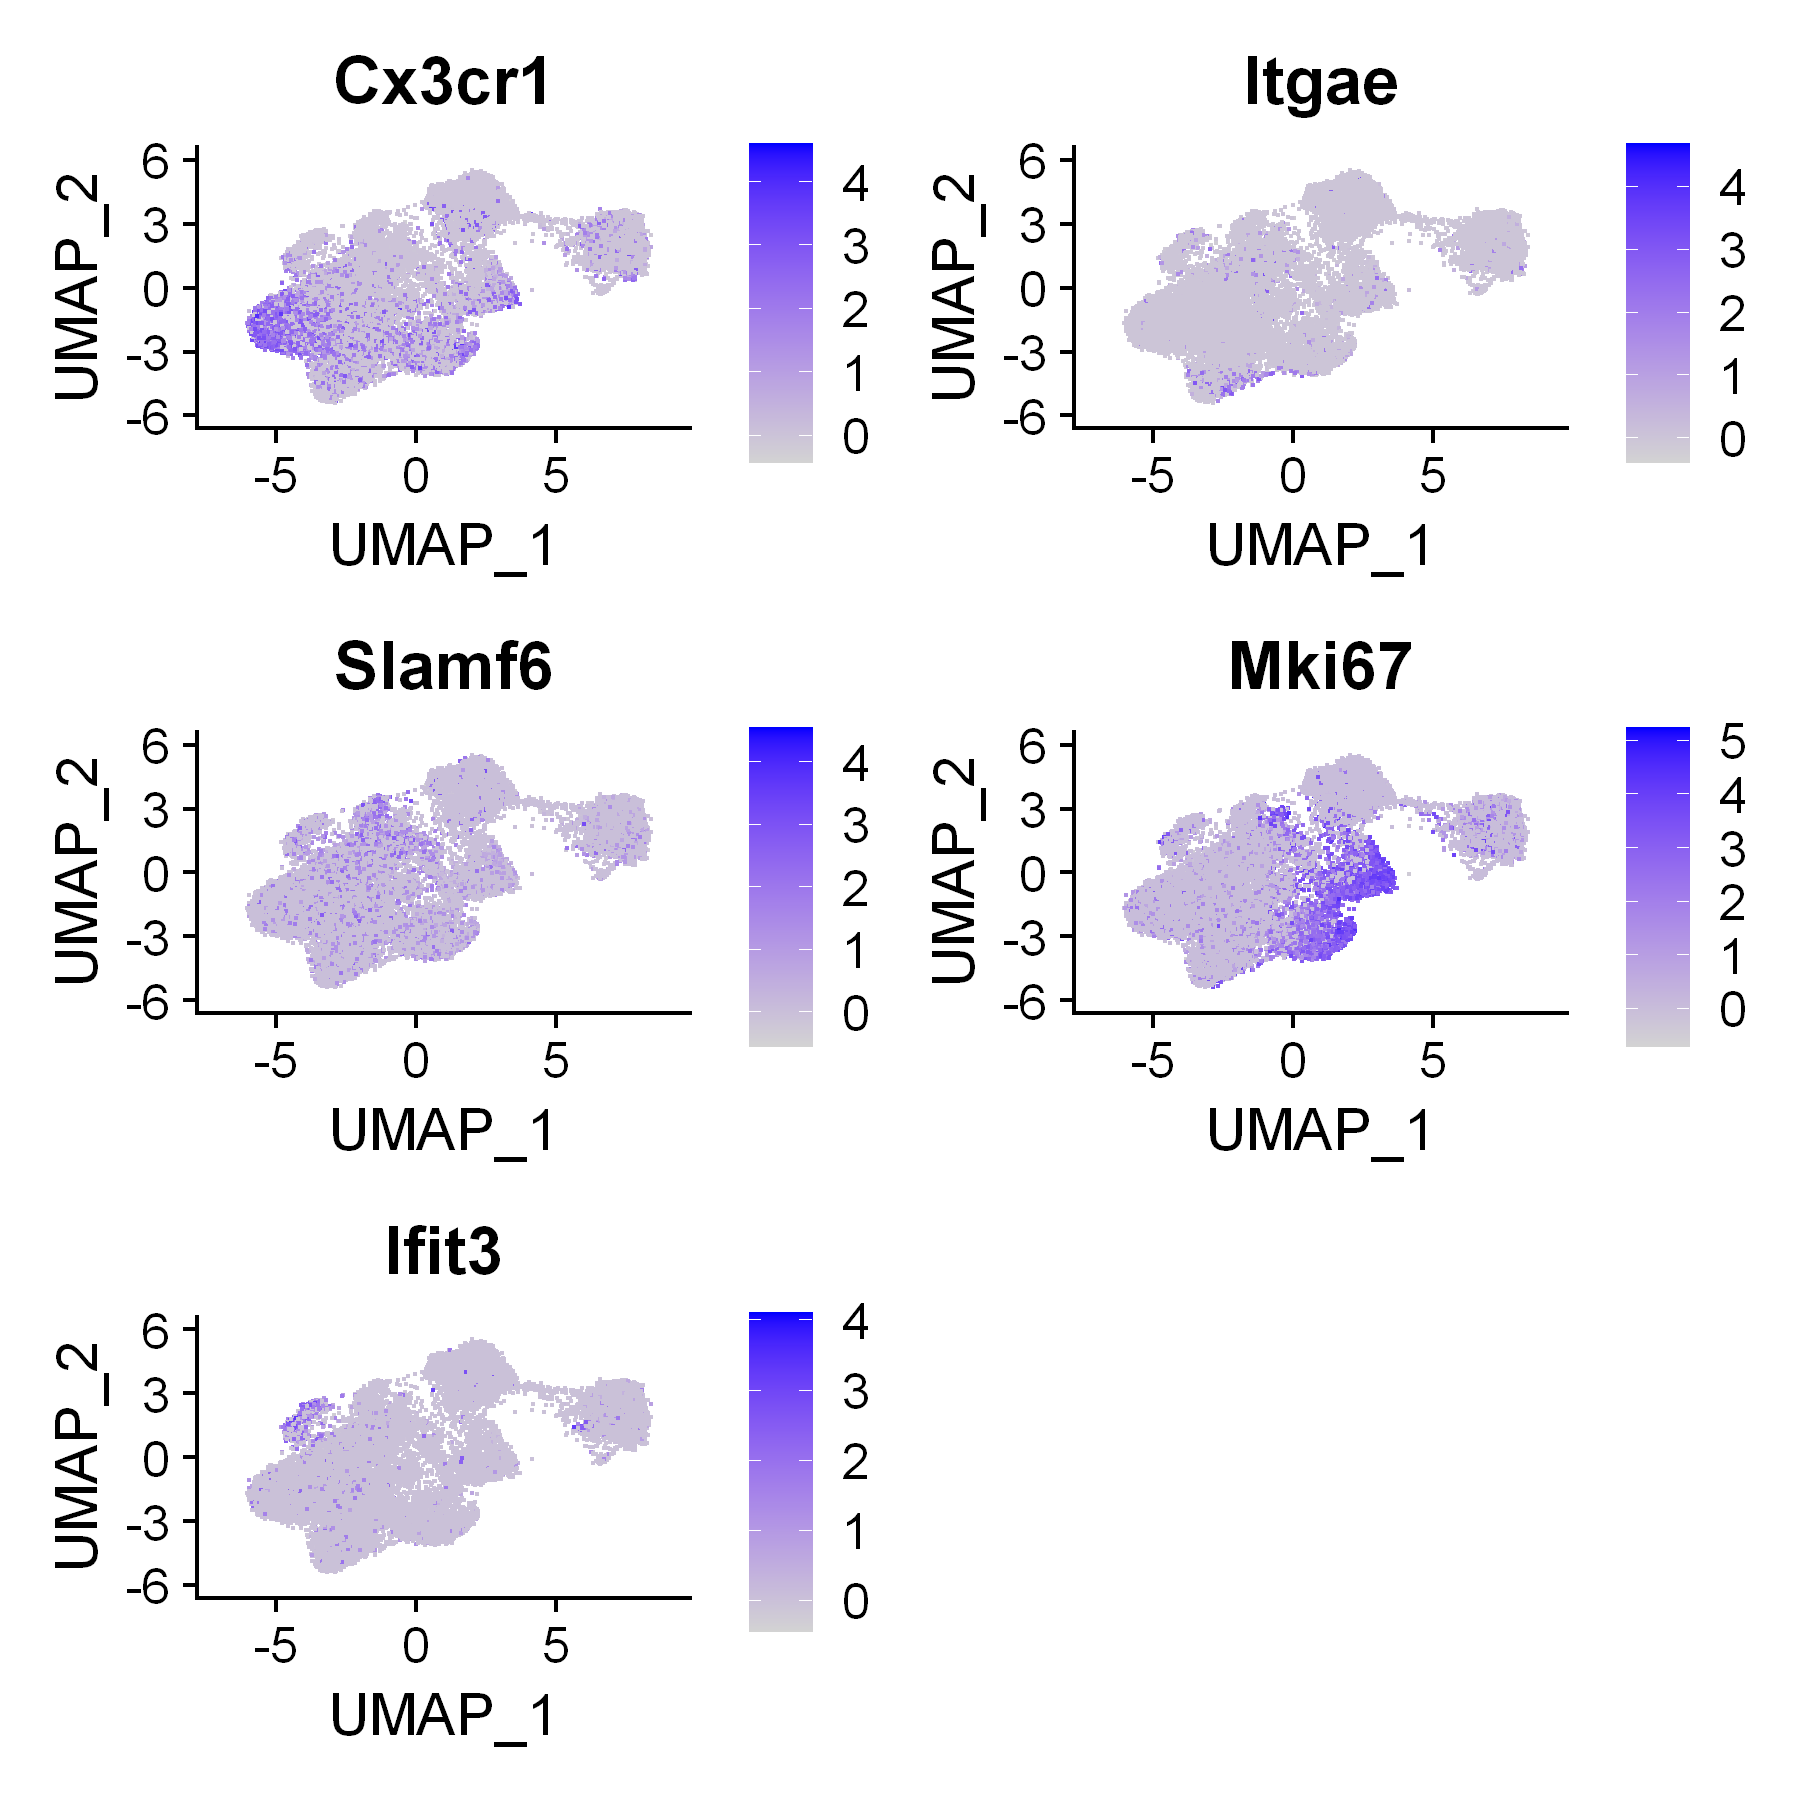

In [72]:
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 6)
FeaturePlot(seurat, c('Cx3cr1', 'Itgae', 'Slamf6', 'Mki67', 'Ifit3'))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18651
Number of edges: 541668

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8826
Number of communities: 9
Elapsed time: 8 seconds


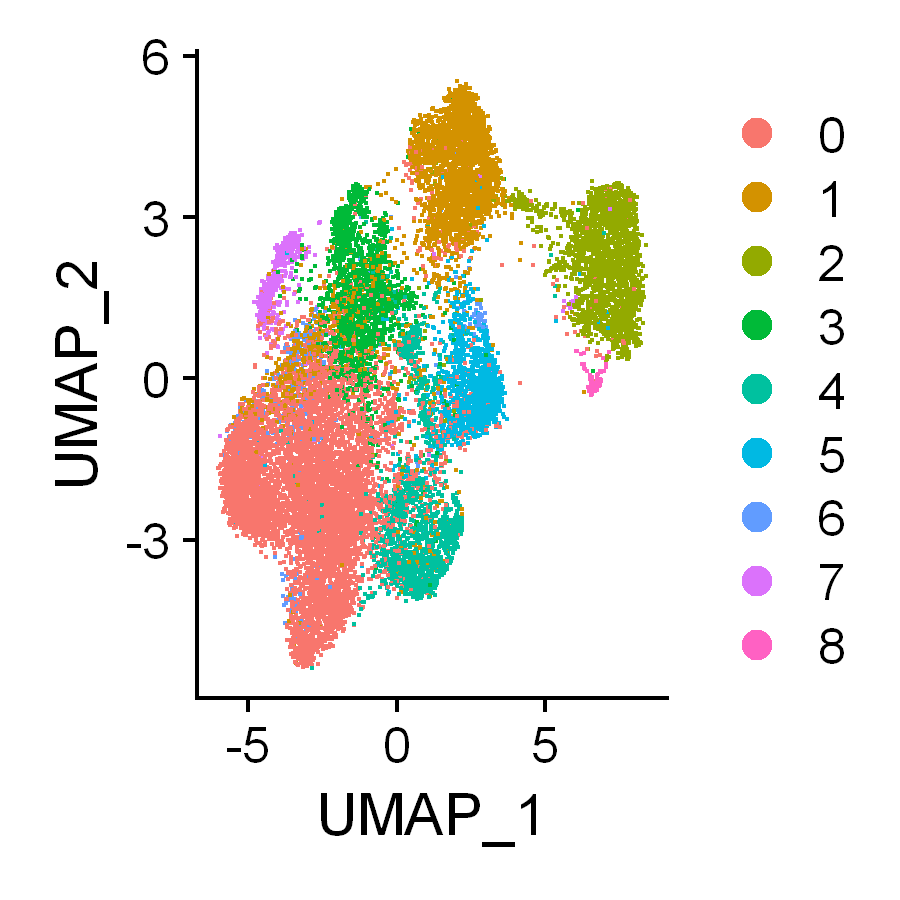

In [124]:
options(repr.plot.width = 3, repr.plot.height = 3)
seurat = FindNeighbors(seurat, dims = 1:10)
seurat = FindClusters(seurat, resolution = .3)
DimPlot(seurat)

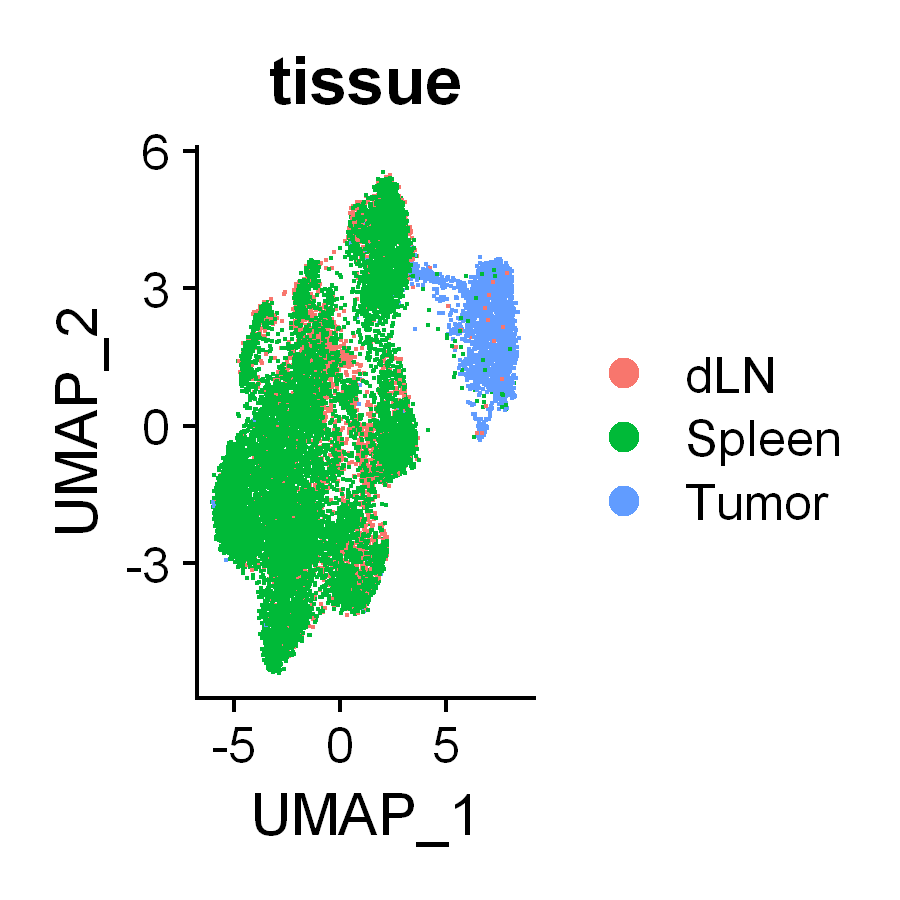

In [120]:
DimPlot(seurat, group = 'tissue')

In [121]:
a = FindMarkers(seurat, 2, logfc.threshold = .5, only.pos = TRUE)
head(a, 60)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mmu-mir-6236,0.0000000000,1.316081,0.998,1.000,0
Gm26917,0.0005918102,1.330599,0.570,0.706,1


Regressing out nFeature_RNA, percent.mito, S.Score, G2M.Score

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 12 features requested have zero variance (running reduction without them): Aldh1l2, Tbx19, Gm15270, Gm24145, Pygo1, Tdo2, Msx1, Styxl1, Abcc2, P2rx5, Prss55, Tigd4"
PC_ 1 
Positive:  Tnfaip3, Rgs16, Vps37b, Pdcd1, Ctla4, Fosl2, Nr4a3, Sik1, Crem, Icos 
	   Nr4a2, Dusp5, Bhlhe40, Pde4d, Dgat1, Litaf, Ifngr1, Neurl3, Nr4a1, Odc1 
	   Skil, Tgif1, Sh2d2a, Dusp4, Tnfrsf1b, Bcl2l11, P2ry10, Tnfrsf9, Zc3h12a, Mxd1 
Negative:  Rasgrp2, Flna, Pycard, Actb, Gzma, Anxa6, Emp3, Sell, Cd48, Coro1a 
	   S100a10, Cdc25b, E2f2, S1pr5, Itgb1, Cx3cr1, Racgap1, Ighg1, Fcgrt, Ahnak 
	   Dapl1, Gzmm, Id3, Cd7, Atic, Dnah8, mt-Nd1, Crip1, Rom1, Il7r 
PC_ 2 
Positive:  Ahnak, Lgals1, S100a4, Ccl5, Lgals3, Ccr2, S100a10, Vim, Gzma, S100a6 
	   Gzmb, Cx3cr1, Id2, Itgax, Il18rap, Anxa6, Klrg1, Crip1, Actb, Plek 
	   

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15439
Number of edges: 565141

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8893
Number of communities: 12
Elapsed time: 5 seconds


2 singletons identified. 10 final clusters.

21:04:07 UMAP embedding parameters a = 0.9922 b = 1.112

21:04:07 Read 15439 rows and found 50 numeric columns

21:04:07 Using Annoy for neighbor search, n_neighbors = 30

21:04:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:04:14 Writing NN index file to temp file C:\Users\dmorgan\AppData\Local\Temp\1\Rtmp8AekIW\fileaa845394c21

21:04:14 Searching Annoy index using 1 thread, search_k = 3000

21:04:24 Annoy recall = 100%

21:04:25 Commencing smooth kNN distance calibration using 1 thread

21:04:27 Initializing from normalized Laplacian + noise

21:04:28 Commencing optimization for 200 epochs, with 706344 positive edges

21:05:07 Optimization finished



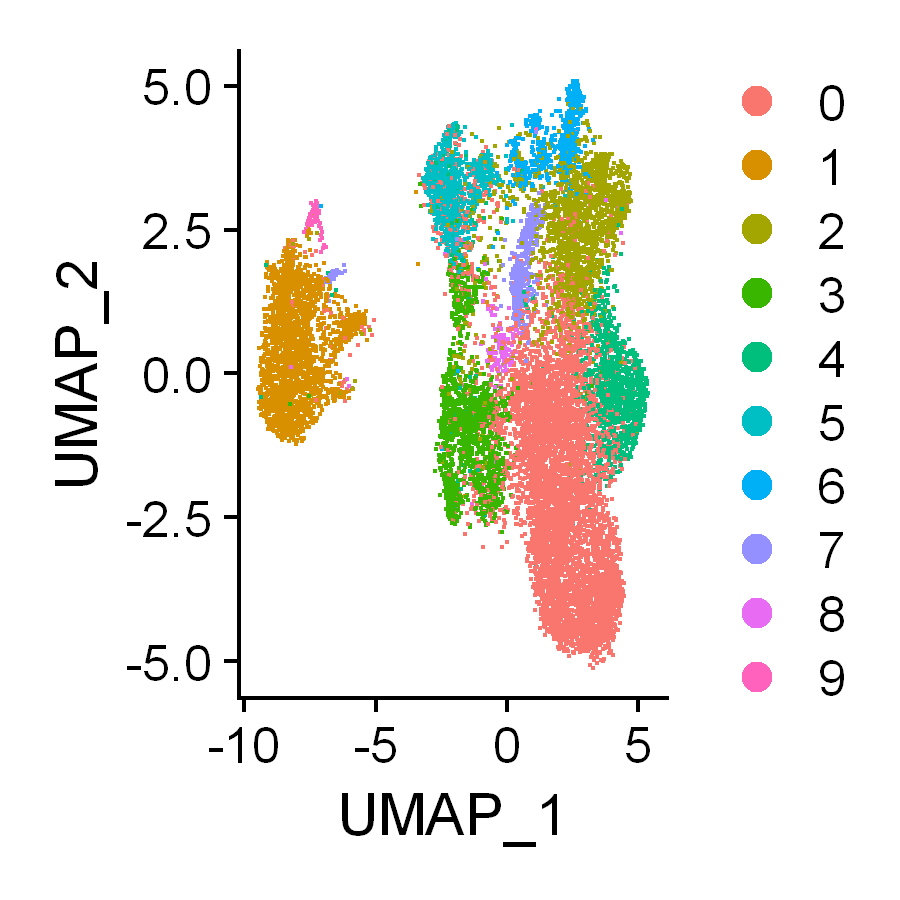

In [128]:
DefaultAssay(seurat) = 'integrated'
seurat2 = subset(seurat, cells = colnames(seurat)[seurat$integrated_snn_res.0.3 != 1])
seurat2 = ScaleData(seurat2, vars.to.regress = c('nFeature_RNA', 'percent.mito', 'S.Score','G2M.Score'), features = VariableFeatures(seurat2))
seurat2 = RunPCA(seurat2, features = VariableFeatures(seurat2), npcs = 100)
seurat2 = FindNeighbors(seurat2, dims = 1:50)
seurat2 = FindClusters(seurat2, resolution = .3)
seurat2 = RunUMAP(seurat2, dims = 1:50)

DimPlot(seurat2)

Regressing out nFeature_RNA, percent.mito, S.Score, G2M.Score

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 17 features requested have zero variance (running reduction without them): Aldh1l2, Gm17281, Tbx19, Xpnpep2, Gm15270, Gm24145, Igf2, Il12a, Pygo1, Tdo2, Lmod3, Msx1, Styxl1, Abcc2, P2rx5, Prss55, Tigd4"
PC_ 1 
Positive:  Tnfaip3, Vps37b, Rgs16, Ctla4, Pdcd1, Fosl2, Nr4a3, Sik1, Crem, Icos 
	   Nr4a2, Pde4d, Dusp5, Bhlhe40, Dgat1, Litaf, Neurl3, Ifngr1, Odc1, Tnfrsf9 
	   Skil, Nr4a1, Tgif1, Sh2d2a, Dusp4, Bcl2l11, Tnfrsf1b, P2ry10, Zc3h12a, Mxd1 
Negative:  Rasgrp2, Flna, Pycard, Actb, Anxa6, Gzma, S100a10, Cd48, Emp3, Ahnak 
	   Coro1a, Itgb1, E2f2, Cdc25b, S1pr5, Cx3cr1, Lgals1, Racgap1, Fcgrt, Ccl5 
	   Sell, Crip1, Ighg1, Cd7, Gzmm, Rom1, Itgam, Ggt1, Rxra, Itgax 
PC_ 2 
Positive:  mmu-mir-6236, Malat1, Lars2, Hist1h2ab, Hist1h1b, Hist1h3c, Hist1h2ae, Hist1h1d, Hist1h2an, Gm23935 
	   His

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14753
Number of edges: 541211

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8849
Number of communities: 11
Elapsed time: 5 seconds


2 singletons identified. 9 final clusters.

21:11:41 UMAP embedding parameters a = 0.9922 b = 1.112

21:11:41 Read 14753 rows and found 50 numeric columns

21:11:41 Using Annoy for neighbor search, n_neighbors = 30

21:11:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:11:46 Writing NN index file to temp file C:\Users\dmorgan\AppData\Local\Temp\1\Rtmp8AekIW\fileaa86ba634

21:11:46 Searching Annoy index using 1 thread, search_k = 3000

21:11:52 Annoy recall = 100%

21:11:53 Commencing smooth kNN distance calibration using 1 thread

21:11:55 Initializing from normalized Laplacian + noise

21:11:56 Commencing optimization for 200 epochs, with 671852 positive edges

21:12:26 Optimization finished



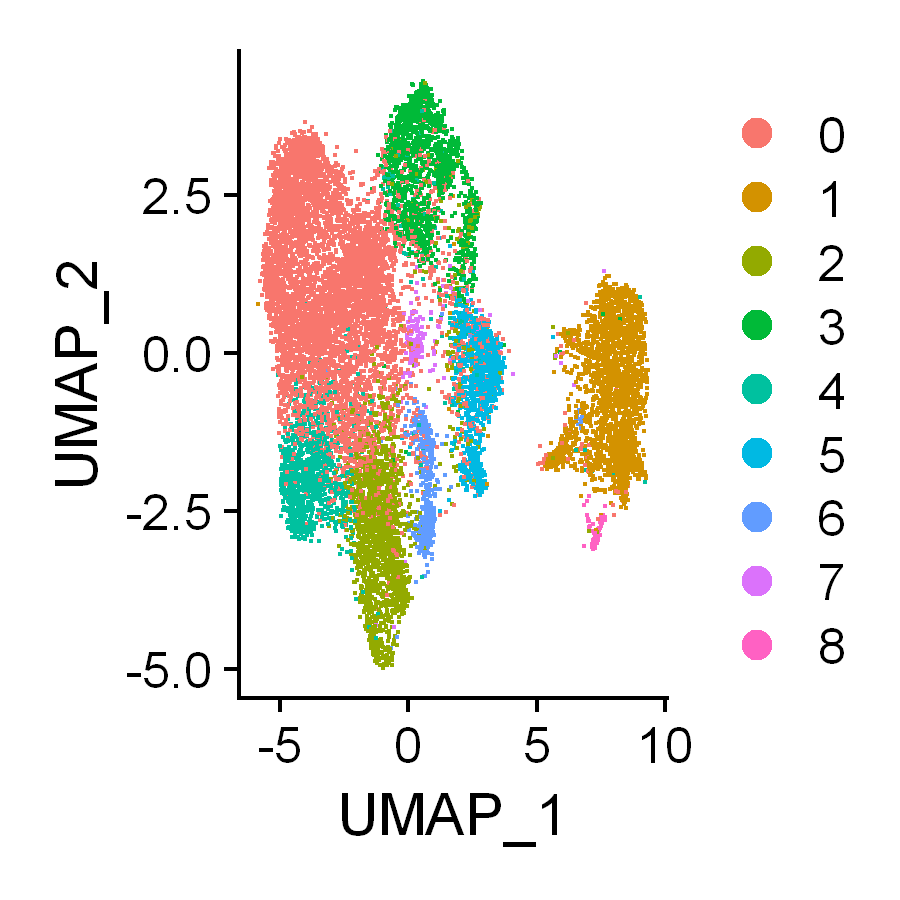

In [134]:
DefaultAssay(seurat2) = 'integrated'
seurat3 = subset(seurat2, cells = colnames(seurat2)[seurat2$integrated_snn_res.0.3 != 6])
seurat3 = ScaleData(seurat3, vars.to.regress = c('nFeature_RNA', 'percent.mito', 'S.Score','G2M.Score'), features = VariableFeatures(seurat3))
seurat3 = RunPCA(seurat3, features = VariableFeatures(seurat3), npcs = 100)
seurat3 = FindNeighbors(seurat3, dims = 1:50)
seurat3 = FindClusters(seurat3, resolution = .3)
seurat3 = RunUMAP(seurat3, dims = 1:50)

DimPlot(seurat3)

In [136]:
seurat3

An object of class Seurat 
34440 features across 14753 samples within 2 assays 
Active assay: integrated (17220 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Regressing out nFeature_RNA, percent.mito, S.Score, G2M.Score

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 18 features requested have zero variance (running reduction without them): Aldh1l2, Gm17281, Tbx19, Xpnpep2, Gm15270, Gm24145, Igf2, Il12a, Pygo1, Tdo2, Lmod3, Msx1, Styxl1, Abcc2, Foxc1, P2rx5, Prss55, Tigd4"
PC_ 1 
Positive:  Tnfaip3, Vps37b, Rgs16, Ctla4, Pdcd1, Fosl2, Nr4a3, Sik1, Crem, Icos 
	   Nr4a2, Pde4d, Dusp5, Bhlhe40, Dgat1, Litaf, Neurl3, Ifngr1, Tnfrsf9, Odc1 
	   Skil, Nr4a1, Tgif1, Sh2d2a, Dusp4, Bcl2l11, Tnfrsf1b, P2ry10, Zc3h12a, Gp49a 
Negative:  Rasgrp2, Flna, Pycard, Actb, Anxa6, Gzma, S100a10, Cd48, Emp3, Ahnak 
	   Coro1a, Itgb1, E2f2, Cdc25b, S1pr5, Cx3cr1, Sell, Racgap1, Fcgrt, Lgals1 
	   Ccl5, Ighg1, Crip1, Cd7, Gzmm, Rom1, Itgam, Ggt1, Rxra, Il7r 
PC_ 2 
Positive:  mmu-mir-6236, Malat1, Lars2, Hist1h2ab, Hist1h1b, Hist1h3c, Hist1h1d, Hist1h2ae, Hist1h2an, Gm23935 


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14675
Number of edges: 537354

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8819
Number of communities: 10
Elapsed time: 4 seconds


2 singletons identified. 8 final clusters.

21:19:37 UMAP embedding parameters a = 0.9922 b = 1.112

21:19:37 Read 14675 rows and found 50 numeric columns

21:19:37 Using Annoy for neighbor search, n_neighbors = 30

21:19:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:19:42 Writing NN index file to temp file C:\Users\dmorgan\AppData\Local\Temp\1\Rtmp8AekIW\fileaa835213a0a

21:19:42 Searching Annoy index using 1 thread, search_k = 3000

21:19:49 Annoy recall = 100%

21:19:49 Commencing smooth kNN distance calibration using 1 thread

21:19:52 Initializing from normalized Laplacian + noise

21:19:52 Commencing optimization for 200 epochs, with 668662 positive edges

21:20:17 Optimization finished



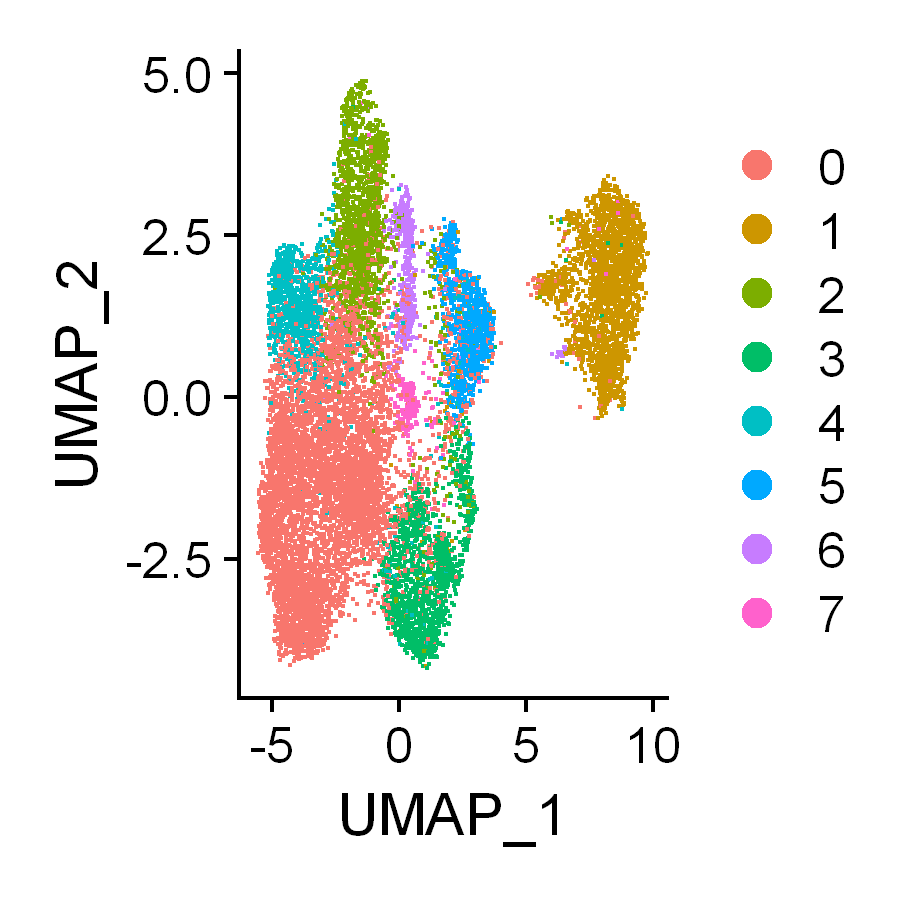

In [138]:
DefaultAssay(seurat3) = 'integrated'
seurat4 = subset(seurat3, cells = colnames(seurat3)[seurat3$integrated_snn_res.0.3 != 8])
seurat4 = ScaleData(seurat4, vars.to.regress = c('nFeature_RNA', 'percent.mito', 'S.Score','G2M.Score'), features = VariableFeatures(seurat4))
seurat4 = RunPCA(seurat4, features = VariableFeatures(seurat4), npcs = 100)
seurat4 = FindNeighbors(seurat4, dims = 1:50)
seurat4 = FindClusters(seurat4, resolution = .3)
seurat4 = RunUMAP(seurat4, dims = 1:50)

DimPlot(seurat4)

In [140]:
a = FindMarkers(seurat4, 7, only.pos = TRUE, logfc.threshold = 1)
head(a, 60)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AW112010,7.993839e-44,1.321486,0.927,0.689,1.376539e-39
Chst2,1.516400e-42,1.493727,0.548,0.156,2.611240e-38
Lag3,7.633564e-31,1.387744,0.593,0.246,1.314500e-26
Tox,2.330924e-30,1.481723,0.492,0.161,4.013852e-26
Adam19,2.718199e-30,1.335467,0.763,0.474,4.680739e-26
Ccl3,9.165265e-30,1.949237,0.384,0.106,1.578259e-25
Ctla2a,2.205607e-29,1.495662,0.836,0.581,3.798056e-25
Ccl5,1.191838e-24,1.199655,0.977,0.914,2.052345e-20
Tigit,1.054013e-23,1.031859,0.576,0.295,1.815011e-19


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14675
Number of edges: 452650

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8470
Number of communities: 10
Elapsed time: 4 seconds


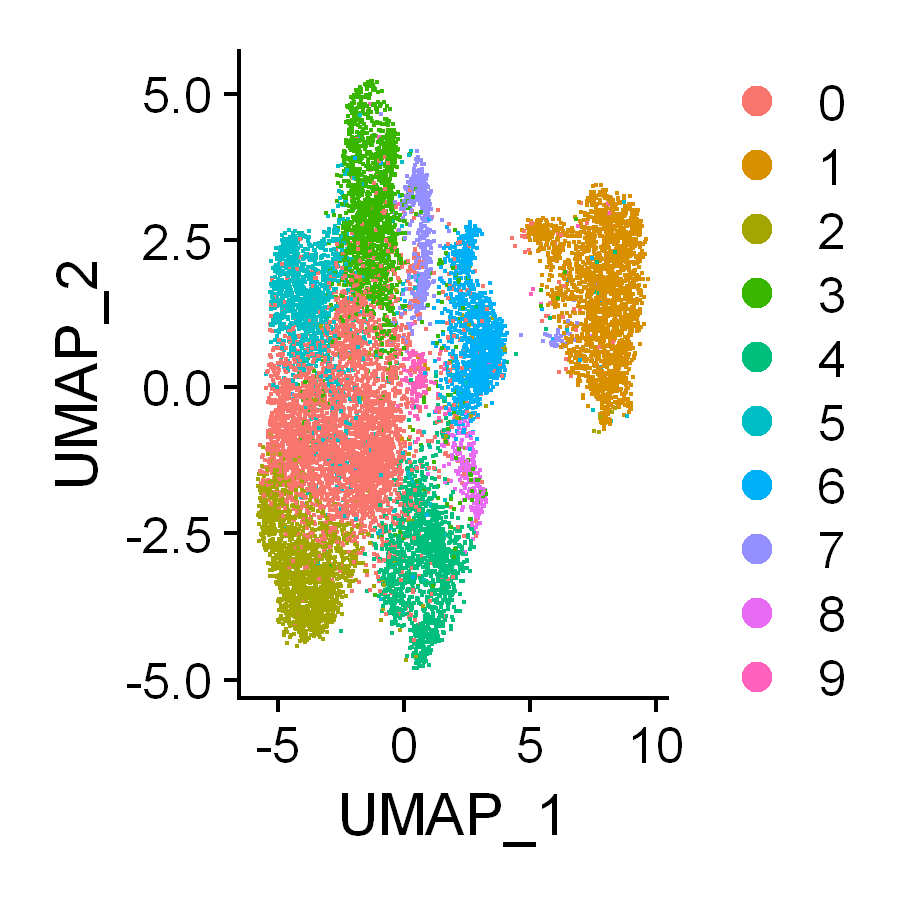

In [231]:
seurat4 = FindNeighbors(seurat4, dims = 1:20)
seurat4 = FindClusters(seurat4, resolution = .5)
#seurat4 = RunUMAP(seurat4, dims = 1:50)

DimPlot(seurat4)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14675
Number of edges: 452650

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8470
Number of communities: 10
Elapsed time: 3 seconds


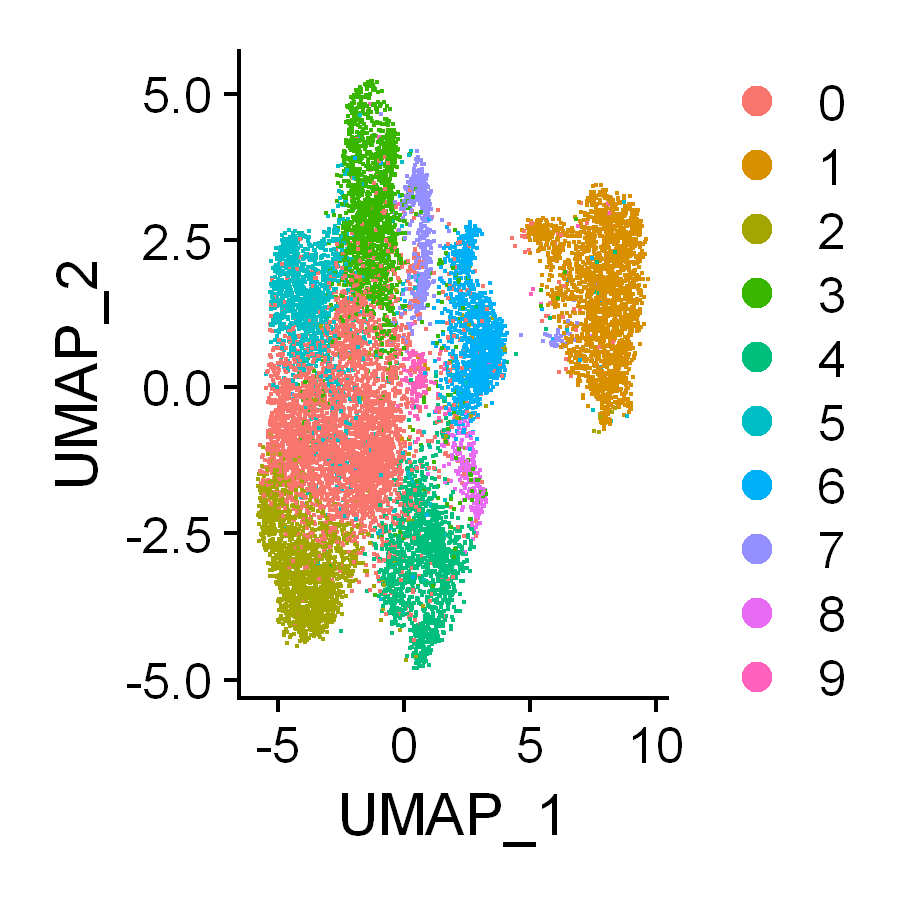

In [228]:
#seurat4 = FindNeighbors(seurat4, dims = 1:20)
#seurat4 = FindClusters(seurat4, resolution = .5)
seurat4 = RunUMAP(seurat4, dims = 1:50, verbose = FALSE, min.dist = .4)
DimPlot(seurat4)

In [229]:
saveRDS(seurat4, 'seurat_clustered.RDS')